In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np

import mahotas as mh

from skimage import io
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local
from skimage.filters import sobel

dapi_path = "/media/ula/D/adam_catfish/catfish_dapi_tst.gif"
homer_path = "/media/ula/D/adam_catfish/catfish_homer_tst.gif"
arc_path = "/media/ula/D/adam_catfish/catfish_arc_tst.gif"

In [2]:
def get_frac_thresh(arr, frac):
    min_lum = np.min(arr)
    max_lum = np.max(arr)
    return min_lum + frac*(max_lum - min_lum)

In [3]:
def thresholding_and_segmentation(img_path):
    
    image = io.imread(img_path)
    
    image = rgb2gray(image)
    
    radius = 30
    selem = disk(radius)

    thre = get_frac_thresh(image, 0.2)
    
    thresholded = image > thre
    bw = closing(thresholded)
    label_image = label(bw)

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(thresholded)

    areas = np.array([])
    
    locations = np.array([])
    
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        locations = np.append(locations, region)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
        
        ax.add_patch(rect)


    ax.set_axis_off()

    fig.tight_layout()
    plt.show()
    return locations

<IPython.core.display.Javascript object>


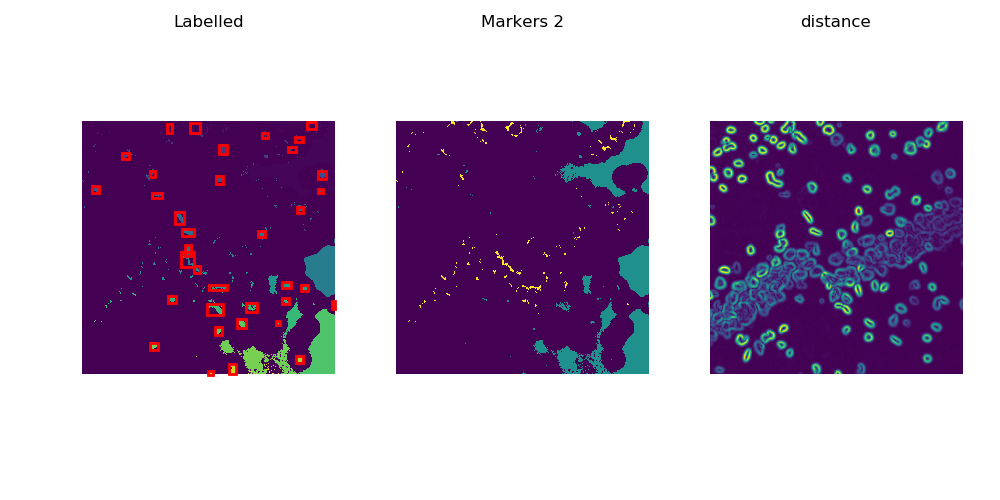

<IPython.core.display.Javascript object>


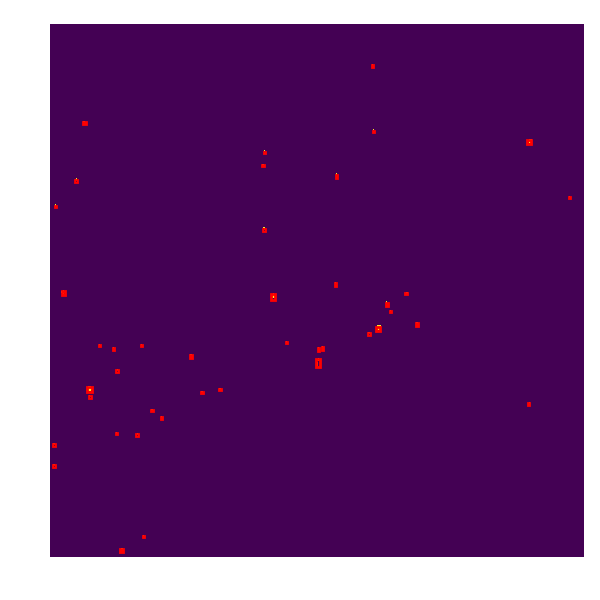

<IPython.core.display.Javascript object>


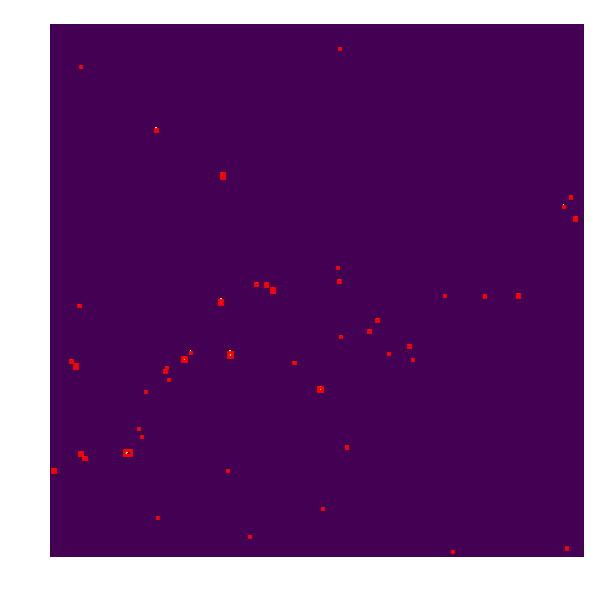

In [4]:
image = io.imread(dapi_path)

def dapi_segmentation(image_ts, footprint_size, thresh_up, sobel_g=False): 
    #image_ts = mh.gaussian_filter(image_ts, 2.)
    T_mean = image.mean()

    opened = opening(image_ts > T_mean, square(3))
    bw = closing(opened, square(3))

    local_thresh = threshold_local(image_ts, 51, offset=7)
    binary_local = image_ts > local_thresh

    local_masked_global = np.ma.masked_array(data = binary_local, mask = ~bw, fill_value = 0).filled()

    elev_map = sobel(mh.gaussian_filter(image_ts,2))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]

    markers2 = np.zeros_like(image_ts)
    markers2[image_ts > local_thresh*5] = 1
    markers2[image_ts < local_thresh/5] = 2
   
    labels = watershed(-elev_map, markers2, mask=local_masked_global)

    label_image = label(labels, connectivity = 1)
    

    fig, axes = plt.subplots(ncols=3, figsize=(10, 5), sharex=True, sharey=True)
    ax = axes.ravel()

    #ax[0].imshow(label_image)
    #ax[0].set_title("Multi")
    ax[0].imshow(label_image)
    ax[0].set_title("Labelled")

    ax[1].imshow(markers2)
    ax[1].set_title("Markers 2")
    
    if(sobel_g):
        ax[2].imshow(elev_map)
        ax[2].set_title("distance")

    areas = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image):
         # take regions with large enough areas
        areas = np.append(areas, region.area)


    std = np.std(areas)
    mean = np.mean(areas)

    thresh_down = 60

    nuclei = np.array([])

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)

         # take regions with large enough areas
        if region.area >= thresh_up:
            #ax[0].add_patch(rect)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            nuclei = np.append(nuclei, region)
    #       draw rectangle around segmented coins        
            ax[0].add_patch(rect)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return nuclei, regions_to_reconsider

nuclei, regions_to_reconsider = dapi_segmentation(image, 18, 450,sobel_g = True)
    
arc_locations = thresholding_and_segmentation(arc_path)
homer_locations = thresholding_and_segmentation(homer_path)

In [ ]:
arc_positive = np.array([])
to_reevaluate = np.array([])

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)

for nucleus in nuclei:
    arc_no = 0
    for arc_dot in arc_locations:
        nucleus_coords_set = set(tuple([m, n]) for m, n in zip(nucleus.coords[:,0], nucleus.coords[:,1]))
        arc_coords_set = set(tuple([m, n]) for m, n in zip(arc_dot.coords[:,0], arc_dot.coords[:,1]))      
        if (len(nucleus_coords_set) == len(nucleus_coords_set.union(arc_coords_set))):
            arc_positive = np.append(arc_positive, arc_dot)

            minr, minc, maxr, maxc = nucleus.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                              fill=False, edgecolor='green', linewidth=1)
            ax.add_patch(rect)     
            minr, minc, maxr, maxc = arc_dot.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                              fill=False, edgecolor='red', linewidth=1)
            arc_no +=1

            ax.add_patch(rect)   
    if arc_no > 1:
        to_reevaluate = np.append(to_reevaluate, nucleus)
            
ax.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
def widen_bbox(bbox, margin, shape):
    return (max(bbox[0] - margin, 0), max(bbox[1] - margin, 0),
           min(bbox[0] +margin, shape[0]), min(bbox[1] + margin, shape[1]))

In [ ]:
#fig, axes = plt.subplots(nrows = len(regions_to_reconsider), sharex=True, sharey=True,figsize=(15,55))
#ax = axes.ravel()
#plt.ioff()

for reg_to_reev in regions_to_reconsider:
    widened_box = widen_bbox(reg_to_reev.bbox, 50, image.shape)
    dapi_segmentation(image[widened_box[0]:widened_box[2],widened_box[1]:widened_box[3]], 15, 500, sobel_g=True)
    #ax_.imshow(image[widened_box[0]:widened_box[2],widened_box[1]:widened_box[3]])
    #ax_.set_axis_off()

#fig.tight_layout()
#plt.show()

In [ ]:
len(imgs_to_reconsider)